In [1]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import time
from collections import namedtuple
import cPickle as pickle
import pandas as pd

import pyspark
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.classification import SVMWithSGD, SVMModel

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random
from sklearn.metrics import coverage_error
import sklearn.metrics
from gensim.models.doc2vec import Doc2Vec, LabeledSentence
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
import logging
from logging import info
from functools import partial

In [2]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [3]:
IS_SAMPLE = True

In [4]:
SVM_SEED = 1234
DOC2VEC_SEED = 1234

In [5]:
NUMBER_INDICATOR = "number_inidicator"
CURRENCY_INDICATOR = "currency_inidicator"
CHEMICAL_INDICATOR = "chemical_inidicator"
MIN_WORD_COUNT = 5
MIN_SIZE = 0
NUM_CORES = 20

In [6]:
GLOBAL_VARS = namedtuple('MODEL_NAME', 'DOC2VEC_MODEL', 'SVM_MODEL_NAME')

class MODEL_NAME(tuple):
    'MODEL_NAME(DOC2VEC_MODEL,)'

    __slots__ = ()

    _fields = ('DOC2VEC_MODEL',)

    def __new__(_cls, DOC2VEC_MODEL,):
        'Create new instance of MODEL_NAME(DOC2VEC_MODEL,)'
        return _tuple.__new__(_cls, (DOC2VEC_MODEL,))

    @classmethod
    def _make(cls, iterable, new=tuple.__new__, len=len):
        'Make a new MODEL_NAME object from a sequence or iterable'
        result = new(cls, iterable)
        if len(result) != 1:
            raise TypeError('Expected 1 arguments, got %d' % len(result))
        return result

    def __repr__(self):
        'Return a nicely formatted representation string'
        return 'MODEL_NAME(DOC2VEC_MODEL=%r)' % self

    def _asdict(self):
        'Return a new OrderedDict which maps field names to their values'
        return OrderedDict(zip(self._fields, self))

    def _replace(_self, **kwds):
        'Return a new MODEL_NAME object replacing specified fields with new values'
        result = _self._ma

In [7]:
SAMPLE_RATIO = 0.0001

In [8]:
VOCAB_MODEL = "vocab_model"
MODEL_PREFIX = "model"
VALIDATION_MATRIX = "validation_matrix.pkl"
METRICS = "metrics.pkl"

In [9]:
#training_file = "/home/local/shalaby/docs_output_sample_100.json"

save_parent_location = "hdfs://deka.cip.ifi.lmu.de/pg-vectors/"
if IS_SAMPLE: 
    save_parent_location = save_parent_location + "sample_" + str(SAMPLE_RATIO) + "/"


root_location = "/big/s/shalaby/"
exports_location = root_location + "exported_data/"

doc2vec_model_save_location = os.path.join(root_location, "parameter_search_doc2vec_models", "sample_" + str(SAMPLE_RATIO))
if not os.path.exists(doc2vec_model_save_location):
    os.makedirs(doc2vec_model_save_location)
if not os.path.exists(os.path.join(doc2vec_model_save_location, VOCAB_MODEL)):
    os.makedirs(os.path.join(doc2vec_model_save_location, VOCAB_MODEL))

#training_file = root_location + "docs_output.json"
training_file = root_location + 'docs_output_training_validation_documents_' + str(SAMPLE_RATIO)

doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
training_docs_list_file = exports_location + "training_documents_" + str(SAMPLE_RATIO) + "_sample.pkl"
validation_docs_list_file = exports_location + "validation_documents_" + str(SAMPLE_RATIO) + "_sample.pkl"

In [10]:
%%time
doc_classification_map = pickle.load(open(doc_classifications_map_file))
sections = pickle.load(open(sections_file))
classes = pickle.load(open(classes_file))
subclasses = pickle.load(open(subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))

CPU times: user 25.1 s, sys: 1.03 s, total: 26.2 s
Wall time: 26.7 s


In [11]:
len(training_docs_list)

8979

In [12]:
len(validation_docs_list)

1969

In [13]:
def stemtokenizer(text):
    """ MAIN FUNCTION to get clean stems out of a text. A list of clean stems are returned """
    tokenizer = RegexpTokenizer(r'\s+', gaps=True)
    tokens = tokenizer.tokenize(text)
    stems = []  # result
    for token in tokens:
        stem = token.lower()
        stem = stem.strip(string.punctuation)
        if stem:
            if is_number(stem):
                stem = NUMBER_INDICATOR
            elif is_currency(stem):
                stem = CURRENCY_INDICATOR
            elif is_chemical(stem):
                stem = CHEMICAL_INDICATOR
            else:
                stem = stem.strip(string.punctuation)
            if stem and len(stem) >= MIN_SIZE:
                # extract uni-grams
                stems.append(stem)
    del tokens
    return stems

def is_number(str):
    """ Returns true if given string is a number (float or int)"""
    try:
        float(str.replace(",", ""))
        return True
    except ValueError:
        return False

def is_currency(str):
    return str[0] == "$"

def is_chemical(str):
    return str.count("-") > 3

In [14]:
def get_training_vector(classification, term_list, classifications, number_of_terms):
    clss = 1 if classification in classifications else 0
    return LabeledPoint(clss, SparseVector(number_of_terms, term_list))

def train_level_new(docs_index, classification, doc_classification_map, number_of_terms):
    training_vectors = docs_index.map(
        lambda (doc_id, postings): get_training_vector(classification, postings,
                                                        doc_classification_map[doc_id], number_of_terms))
    svm = SVMWithSGD.train(training_vectors, iterations=SVM_ITERATIONS, convergenceTol=SVM_CONVERGENCE, regParam=SVM_REG)
    return training_vectors, svm

get_binary = lambda x: 1 if x > 0 else 0
get_binary = np.vectorize(get_binary)


def get_top_N_percentage(y_score, y_true, max_N=3):
    """
    Get percentage of correct labels that are in the top N scores
    """
    num_all_true = 0
    num_found_in_max_N = 0
    for i in xrange(y_score.shape[0]):
        y_score_row = y_score[i,:]
        y_true_row = y_true[i,:]
        desc_score_indices = np.argsort(y_score_row)[::-1]
        true_indices = np.where(y_true_row ==1)[0]
        
        num_true_in_row = len(true_indices)
        num_all_true += num_true_in_row
        for i, score_index in enumerate(desc_score_indices):
            # only iterate through the score list till depth N, but make sure you also account for the case where 
            # the number of true labels for the current row is higher than N
            if i >= max_N and i >= num_true_in_row:
                break
            if score_index in true_indices:
                num_found_in_max_N += 1
    return float(num_found_in_max_N)/ num_all_true


def get_metrics(y_true, y_score, y_binary_score):
    metrics = {}
    metrics['total_positive'] = np.sum(np.sum(y_binary_score))
    #TODO remove those two when running on the whole set to avoid excessive storage costs
    metrics['y_true'] = y_true
    metrics['y_score'] = y_score
    metrics['y_binary_score'] = y_binary_score
    metrics['coverage_error'] = coverage_error(y_true, y_binary_score)
    metrics['average_num_of_labels'] = np.sum(np.sum(y_true, axis=1))/y_true.shape[0]
    metrics['average_precision_micro'] = sklearn.metrics.average_precision_score(y_true, y_binary_score, average='micro')
    metrics['average_precision_macro'] = sklearn.metrics.average_precision_score(y_true, y_binary_score, average='macro')
    metrics['precision_micro'] = sklearn.metrics.precision_score(y_true, y_binary_score, average='micro')
    metrics['precision_macro'] = sklearn.metrics.precision_score(y_true, y_binary_score, average='macro')
    metrics['recall_micro'] = sklearn.metrics.recall_score(y_true, y_binary_score, average='micro')
    metrics['recall_macro'] = sklearn.metrics.recall_score(y_true, y_binary_score, average='macro')
    metrics['f1_micro'] = sklearn.metrics.f1_score(y_true, y_binary_score, average='micro')
    metrics['f1_macro'] = sklearn.metrics.f1_score(y_true, y_binary_score, average='macro')

    precision_scores = np.zeros(y_true.shape[1])
    for i in range(0, y_true.shape[1]):
        precision_scores[i] = sklearn.metrics.precision_score(y_true[:,i], y_binary_score[:,i])
    metrics['precision_scores_array'] = precision_scores.tolist()

    recall_scores = np.zeros(y_true.shape[1])
    for i in range(0, y_true.shape[1]):
        recall_scores[i] = sklearn.metrics.recall_score(y_true[:,i], y_binary_score[:,i])
    metrics['recall_scores_array'] = recall_scores.tolist()

    f1_scores = np.zeros(y_true.shape[1])
    for i in range(0, y_true.shape[1]):
        f1_scores[i] = sklearn.metrics.f1_score(y_true[:,i], y_binary_score[:,i])
    metrics['f1_scores_array'] = f1_scores.tolist()

    metrics['top_1'] = get_top_N_percentage(y_score, y_true, max_N=1)
    metrics['top_3'] = get_top_N_percentage(y_score, y_true, max_N=3)
    metrics['top_5'] = get_top_N_percentage(y_score, y_true, max_N=5)
    
    return metrics

def model_exists(path):
    try:
        model = SVMModel.load(sc, path)
        return True;
    except:
        return False
    
def get_training_vector(classification, dense_vector, classifications):
    clss = 1 if classification in classifications else 0
    return LabeledPoint(clss, dense_vector)

def train_level_doc2vec(classification, doc_classification_map):
    doc2vec_model = GLOBAL_VARS.DOC2VEC_MODEL
    training_vectors = []
    for doc_id in training_docs_list:
        # converting from memmap to a normal array as spark is unable to convert memmap to a spark Vector
        normal_array = []
        normal_array[:] = doc2vec_model.docvecs[doc_id][:]
        training_vectors.append(get_training_vector(classification, normal_array, 
                                                    doc_classification_map[doc_id]))
    info("Finished getting training vectors")
    training_vectors = sc.parallelize(training_vectors)
    info("Finished parallelization")
    svm = SVMWithSGD.train(training_vectors, iterations=SVM_ITERATIONS, convergenceTol=SVM_CONVERGENCE, regParam=SVM_REG)
    return training_vectors, svm

In [59]:
y_true = np.array([[1, 0, 1], [1, 0, 0]])
y_score = np.array([[0.75, 0.5, 1], [1, 0.5, 0.1]])
coverage_error(y_true, y_score)

1.5

In [52]:
y_score = np.array([[-1,0,1,2,3],[-1,0,1,2,3]])
y_true = np.array([[0,0,0,0,1],[0,0,0,1,1]])
get_top_N_percentage(y_score, y_true, max_N=1)

[4 3 2 1 0]
[4]
0 4
found
[4 3 2 1 0]
[3 4]
0 4
found
1 3
found
3
3


1.0

In [15]:
def ensure_hdfs_location_exists(location):
    parent = os.path.dirname(location)
    os.system("hdfs dfs -mkdir -p " + location)
    
def get_svm_model_path(method, classification, reg=SVM_REG, iterations=SVM_ITERATIONS):
    location = os.path.join(save_parent_location, "models", method, 
                            "iter_" + str(iterations) + "_reg_" + str(reg),
                            classification + "_model.svm")
    ensure_hdfs_location_exists(location)
    return location

def get_data_output_name(method, data_type="training"):
    location = os.path.join(save_parent_location, "models", method, 
                            data_type + "_data", 
                            "data.json")
    ensure_hdfs_location_exists(location)
    return location

def get_data_classification_output_name(method, classification, data_type="training"):
    location = os.path.join(save_parent_location, "models", method, 
                            data_type + "_data", 
                            classification + "_data.json")
    ensure_hdfs_location_exists(location)
    return location

def get_prediction_output_name(method, data_type="training", subset="sections", reg=SVM_REG, iterations=SVM_ITERATIONS):
    location = os.path.join(save_parent_location, "models", method,
                            "iter_" + str(iterations) + "_reg_" + str(reg),
                            data_type + "_" + subset + "_predictions.svm")
    ensure_hdfs_location_exists(location)
    return location
    
def get_labels_output_name(data_type="training", subset="sections", reg=SVM_REG, iterations=SVM_ITERATIONS):
    location = os.path.join(save_parent_location, "models", 
                            data_type + "_" + subset + "_labels.svm")
    ensure_hdfs_location_exists(location)
    return location

def get_metrics_output_name(method, data_type="training", subset="sections", reg=SVM_REG, iterations=SVM_ITERATIONS):
    location = os.path.join(save_parent_location, "models", method, 
                            "iter_" + str(iterations) + "_reg_" + str(reg),
                            data_type + "_" + subset + "_metrics.pkl")
    ensure_hdfs_location_exists(location)
    return location    
                            
def get_save_location(location, sample=False):
    if sample:
        return location.replace(save_parent_location, sample_save_parent_location)
    return location

NameError: name 'SVM_REG' is not defined

In [ ]:
def train_classifications(classifications):
    info("====== Doing Training")
    i=0
    for classification in classifications:
        print classification
        try:
            model_path = get_svm_model_path(GLOBAL_VARS.MODEL_NAME, classification)
            if not model_exists(model_path):
                training_vectors, svm = train_level_doc2vec(classification, doc_classification_map)
                svm.save(sc, model_path)
            else:
                print "Model Exists"
        except:
            print "Problem creating: %s: %s" % (classification, GLOBAL_VARS.MODEL_NAME)
            raise

In [ ]:
def do_validation(validation_vectors_matrix, doc_classification_map, classifications, classifications_name):

    info("====== Doing Validation")
    method = GLOBAL_VARS.MODEL_NAME
    subset = classifications_name

    doc_count = validation_vectors_matrix.shape[0]
    y_score = np.zeros((doc_count, len(classifications)))
    y_true = np.zeros((doc_count, len(classifications)))
    i=0

    for classification in classifications:
        print classification

        validation_vectors = get_validation_doc2vec_spark_vectors(validation_vectors_matrix, 
                                                                  classification, doc_classification_map)
        #global binarySvm
        binarySvm = SVMModel.load(sc, get_svm_model_path(GLOBAL_VARS.MODEL_NAME, classification))
        info("Loaded the model, Doing the prediction now....")
        binarySvm.clearThreshold()
        binarySvmB = sc.broadcast(binarySvm)
        # using the broadcasted binarySvm variable, fixes global name 'binarySvm' is not defined as this variable was not
        # available in the workers, so we pass it explicitly to the mapper using partial
        labels_predictions = validation_vectors.map( \
            partial(lambda svm, p: (p.label, svm.value.predict(p.features)), binarySvmB) \
        ).collect()
        #labels = test_labeled_points.map(lambda p: p.labels)
        y_true[:,i] = [label_pred[0] for label_pred in labels_predictions]
        y_score[:,i] = [label_pred[1] for label_pred in labels_predictions]
        i+=1
    y_binary_score = get_binary(y_score)
    # results[method]["y_true"] = y_true
    # results[method]["y_score"] = y_score
    # results[method]["y_binary_score"] = y_binary_score
    metrics = get_metrics(y_true, y_score, y_binary_score)
    return metrics


In [ ]:
def get_validation_docs_with_inference(doc2vec_model, doc_classification_map):
    """
    Use the trained doc2vec model to get the paragraph vector representations of the validation documents
    """
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)):
        validation_vectors_matrix = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)))
    else:
        validation_documents_reps = {}
        validation_vectors = []
        validation_labels = []
        info("===== Getting validation vectors with inference")

        # do inference and store results in dict
        i = 0
        for (doc_id, doc_contents_array) in ValidationDocumentGenerator(training_file, validation_docs_list):
            i += 1
            if i % 1000 == 0: info(str(i))
            validation_documents_reps[doc_id] = doc2vec_model.infer_vector(doc_contents_array)

        # create matrix for the validation vectors
        for validation_doc_id in validation_docs_list:
            validation_vectors.append(validation_documents_reps[validation_doc_id])
            validation_labels.append([classf for classf in doc_classification_map[validation_doc_id] if classf in sections])
        validation_vectors_matrix = np.array(validation_vectors)
        pickle.dump(validation_vectors_matrix, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX), 'w'))
    
    return validation_vectors_matrix

In [ ]:
def get_validation_doc2vec_spark_vectors(validation_vectors_matrix, classification, doc_classification_map):
    validation_vectors = []
    for (index, doc_id) in enumerate(validation_docs_list):
        # converting from memmap to a normal array as spark is unable to convert memmap to a spark Vector
        validation_vector = validation_vectors_matrix[index]
        validation_vectors.append(get_training_vector(classification, validation_vector, 
                                                    doc_classification_map[doc_id]))
    validation_vectors = sc.parallelize(validation_vectors)
    info("Finished getting validation vectors")
    return validation_vectors

In [ ]:
class MetricsGraph:
    def __init__(self):
        self.coverage_errors = []
        self.average_num_labels = []
        
        self.f1_micros = []
        self.precision_micros = []
        self.recall_micros = []
        self.f1_macros = []
        self.precision_macros = []
        self.recall_macros = []
        
        self.top_1s = []
        self.top_3s = []
        self.top_5s = []
        
        self.epochs = []
        
        self.fig = None
        self.ax = None
        self.ax2 = None
    
    def init_graph(self):
        self.fig = plt.figure(figsize=(12,6), dpi=80)
        self.ax = plt.subplot(121)
        self.ax2 = plt.subplot(122)
        self.fig.subplots_adjust(top=0.75, bottom=0.1, left=0.05, right=0.95)
        self.ax.set_xlabel("Epochs")
        self.ax2.set_xlabel("Epochs")
    
    def _add_metrics(self, metrics, epoch):
        self.coverage_errors.append(metrics['coverage_error'])
        self.average_num_labels.append(metrics['average_num_of_labels'])
        
        self.f1_micros.append(metrics['f1_micro'])
        self.precision_micros.append(metrics['precision_micro'])
        self.recall_micros.append(metrics['recall_micro'])
        self.f1_macros.append(metrics['f1_macro'])
        self.precision_macros.append(metrics['precision_macro'])
        self.recall_macros.append(metrics['recall_macro'])
        
        self.top_1s.append(metrics['top_1']  if 'top_1' in metrics else get_top_N_percentage(metrics['y_score'], metrics['y_true'], max_N=1))
        self.top_3s.append(metrics['top_3']  if 'top_3' in metrics else get_top_N_percentage(metrics['y_score'], metrics['y_true'], max_N=3))
        self.top_5s.append(metrics['top_5']  if 'top_5' in metrics else get_top_N_percentage(metrics['y_score'], metrics['y_true'], max_N=5))
        
        self.epochs.append(epoch)
        
    def add_metrics_to_graph(self, metrics, epoch, draw_now=True):
        
        self._add_metrics(metrics, epoch)
        if draw_now:
            self.draw()

    def draw(self):
        
        first_epoch = self.epochs[0]
        last_epoch = self.epochs[-1]
        
        coverage_error_line, = self.ax.plot(self.epochs, self.coverage_errors, 'r-', label='Coverage Error')
        average_num_labels_line, = self.ax.plot(self.epochs, self.average_num_labels, 'g-', label='Average Number of Labels')

        self.ax.legend(handles=[coverage_error_line, average_num_labels_line],
                  bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
        self.ax.axis([first_epoch, last_epoch, 0, 10])
        # show the average number of labels as a separate y-tick
        self.ax.set_yticks(list(self.ax.get_yticks()) + [self.average_num_labels[0]])


        f1_micro_line, = self.ax2.plot(self.epochs, self.f1_micros, 'g-', label='F1 Micro')
        precision_micro_line, = self.ax2.plot(self.epochs, self.precision_micros, 'r-', label='Precision Micro')
        recall_micro_line, = self.ax2.plot(self.epochs, self.recall_micros, 'b-', label='Recall Micro')
        f1_macro_line, = self.ax2.plot(self.epochs, self.f1_macros, 'g--', label='F1 Macro')
        precision_macro_line, = self.ax2.plot(self.epochs, self.precision_macros, 'r--', label='Precision Macro')
        recall_macro_line, = self.ax2.plot(self.epochs, self.recall_macros, 'b--', label='Recall Macro')
        
        top_1_line, = self.ax2.plot(self.epochs, self.top_1s, 'g-.', label='Top 1 %')
        top_3_line, = self.ax2.plot(self.epochs, self.top_3s, 'r-.', label='Top 3 %')
        top_5_line, = self.ax2.plot(self.epochs, self.top_5s, 'b-.', label='Top 5 %')
        
        self.ax2.legend(handles=[f1_micro_line, precision_micro_line, recall_micro_line, 
                                 f1_macro_line, precision_macro_line, recall_macro_line,
                                 top_1_line, top_3_line, top_5_line],
                  bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
        self.ax2.axis([first_epoch, last_epoch, 0, 1])
        
        self.fig.canvas.draw()

<IPython.core.display.Javascript object>


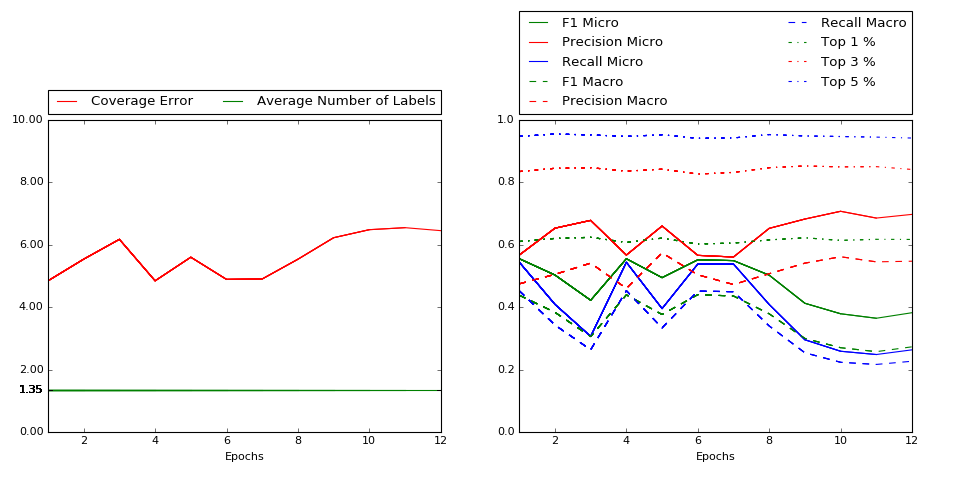

In [96]:
%matplotlib notebook
graph = MetricsGraph()
graph.init_graph()

for epoch in range(1,DOC2VEC_MAX_EPOCHS+1):
    try:
        model_name = placeholder_model_name.format(epoch)
        metrics = pickle.load(open(os.path.join(doc2vec_model_save_location, model_name, METRICS)))
        graph.add_metrics_to_graph(metrics, epoch)
    except IOError:
        break

In [16]:
def add_metrics_to_graph(metrics):
    coverage_errors.append(metrics['coverage_error'])
    topN_avgs.append(metrics['topN_avg'])
    f1_micros.append(metrics['f1_micro'])
    precision_micros.append(metrics['precision_micro'])
    recall_micros.append(metrics['recall_micro'])
    f1_macros.append(metrics['f1_macro'])
    precision_macros.append(metrics['precision_macro'])
    recall_macros.append(metrics['recall_macro'])
    epochs.append(epoch)

    coverage_error_line, = ax.plot(epochs, coverage_errors, 'r-', label='Coverage Error')
    topN_avg_line, = ax.plot(epochs, topN_avgs, 'b-', label='Top N Avg')
    ax.legend(handles=[coverage_error_line, topN_avg_line],
              bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    ax.axis([1,epoch, 0, 10])


    f1_micro_line, = ax2.plot(epochs, f1_micros, 'g-', label='F1 Micro')
    precision_micro_line, = ax2.plot(epochs, precision_micros, 'r-', label='Precision Micro')
    recall_micro_line, = ax2.plot(epochs, recall_micros, 'b-', label='Recall Micro')
    f1_macro_line, = ax2.plot(epochs, f1_macros, 'g--', label='F1 Macro')
    precision_macro_line, = ax2.plot(epochs, precision_macros, 'r--', label='Precision Macro')
    recall_macro_line, = ax2.plot(epochs, recall_macros, 'b--', label='Recall Macro')
    ax2.legend(handles=[f1_micro_line, precision_micro_line, recall_micro_line, f1_macro_line, precision_macro_line, recall_macro_line],
              bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    ax2.axis([1,epoch, 0, 1])

    fig.canvas.draw()

### Doc2vec and SVM Parameters

In [17]:
DOC2VEC_SIZE = 3000
DOC2VEC_WINDOW = 8
DOC2VEC_MAX_VOCAB_SIZE = None
DOC2VEC_SAMPLE = 1e-5
DOC2VEC_TYPE = 1
DOC2VEC_HIERARCHICAL_SAMPLE = 0
DOC2VEC_NEGATIVE_SAMPLE_SIZE = 10
DOC2VEC_CONCAT = 1
DOC2VEC_MEAN = 0
DOC2VEC_TRAIN_WORDS = 0
DOC2VEC_EPOCHS = 1 # we do our training manually one epoch at a time
DOC2VEC_MAX_EPOCHS = 20
REPORT_DELAY = 60 # report the progress every x seconds
REPORT_VOCAB_PROGRESS = 1000 # report the progress every x terms

In [22]:
SVM_ITERATIONS = 1000
SVM_CONVERGENCE = 0.001
SVM_REG = 0.1
GLOBAL_VARS.SVM_MODEL_NAME = 'iter_{}_reg_{}'.format(SVM_ITERATIONS, SVM_REG)

In [23]:
class TrainingDocumentGenerator(object):
    def __init__(self, filename, training_docs_list):
        self.filename = filename
        self.training_docs_list = training_docs_list
    def __iter__(self):
        for line in open(self.filename):
            if not line.strip(): continue
            (doc_id, text) = eval(line)
            if doc_id in self.training_docs_list:
                yield LabeledSentence(words=stemtokenizer(text), tags=[doc_id])
                
class ValidationDocumentGenerator(object):
    def __init__(self, filename, validation_docs_list):
        self.filename = filename
        self.validation_docs_list = validation_docs_list
    def __iter__(self):
        for line in open(self.filename):
            if not line.strip(): continue
            (doc_id, text) = eval(line)
            if doc_id in self.validation_docs_list:
                yield doc_id, stemtokenizer(text)

## Create the Doc2vec model

In [24]:
placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                                DOC2VEC_WINDOW, 
                                                                'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                                DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                                DOC2VEC_TRAIN_WORDS,
                                                                DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                                str(DOC2VEC_MAX_VOCAB_SIZE))
placeholder_model_name = placeholder_model_name + "_curriter_{}"
placeholder_model_name

'doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_{}'

In [25]:
doc2vec_model = Doc2Vec(size=DOC2VEC_SIZE , window=DOC2VEC_WINDOW, min_count=MIN_WORD_COUNT, 
                max_vocab_size= DOC2VEC_MAX_VOCAB_SIZE,
                sample=DOC2VEC_SAMPLE, seed=DOC2VEC_SEED, workers=NUM_CORES,
                # doc2vec algorithm dm=1 => PV-DM, dm=2 => PV-DBOW, PV-DM dictates CBOW for words
                dm=DOC2VEC_TYPE,
                # hs=0 => negative sampling, hs=1 => hierarchical softmax
                hs=DOC2VEC_HIERARCHICAL_SAMPLE, negative=DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                dm_concat=DOC2VEC_CONCAT,
                # would train words with skip-gram on top of cbow, we don't need that for now
                dbow_words=DOC2VEC_TRAIN_WORDS,
                iter=DOC2VEC_EPOCHS)

GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model

In [26]:
%%time
if not os.path.exists(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX)):
    doc2vec_model.build_vocab(sentences=TrainingDocumentGenerator(training_file, training_docs_list), progress_per=REPORT_VOCAB_PROGRESS)
    doc2vec_model.save(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX))
else: 
    doc2vec_model_vocab_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX))
    doc2vec_model.reset_from(doc2vec_model_vocab_model)

2016-09-16 02:45:38,825 : INFO : loading Doc2Vec object from /big/s/shalaby/parameter_search_doc2vec_models/sample_0.0001/vocab_model/model
2016-09-16 02:45:39,979 : INFO : loading docvecs recursively from /big/s/shalaby/parameter_search_doc2vec_models/sample_0.0001/vocab_model/model.docvecs.* with mmap=None
2016-09-16 02:45:39,981 : INFO : loading syn1neg from /big/s/shalaby/parameter_search_doc2vec_models/sample_0.0001/vocab_model/model.syn1neg.npy with mmap=None
2016-09-16 02:47:53,394 : INFO : loading syn0 from /big/s/shalaby/parameter_search_doc2vec_models/sample_0.0001/vocab_model/model.syn0.npy with mmap=None
2016-09-16 02:48:02,476 : INFO : setting ignored attribute syn0norm to None
2016-09-16 02:48:02,478 : INFO : setting ignored attribute cum_table to None
2016-09-16 02:48:02,877 : INFO : using concatenative 51000-dimensional layer1
2016-09-16 02:48:02,879 : INFO : resetting layer weights


CPU times: user 13.4 s, sys: 6.89 s, total: 20.3 s
Wall time: 2min 37s


## Actual Training, validation and Metrics Loop

In [27]:
doc2vec_model.min_alpha = 0.025
epoch_metrics = []

In [ ]:
%%time
start_from = 6
for epoch in range(start_from,DOC2VEC_MAX_EPOCHS+1):
    GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
    info("****************** Epoch {} --- Working on {} *******************".format(epoch, GLOBAL_VARS.MODEL_NAME))
    
    # if we have the model, just load it, otherwise train the previous model
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
        docvec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
    else:
        # train the doc2vec model
        doc2vec_model.train(sentences=TrainingDocumentGenerator(training_file, training_docs_list), report_delay=REPORT_DELAY)
        doc2vec_model.alpha -= 0.001  # decrease the learning rate
        doc2vec_model.min_alpha = doc2vec_model.alpha  # fix the learning rate, no decay
        if not os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME)):
            os.makedirs(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME))
        doc2vec_model.save(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model

    # Training and validation of SVMs using those docvecs
    train_classifications(sections)
    validation_vectors_matrix = get_validation_docs_with_inference(doc2vec_model, doc_classification_map)
    metrics = do_validation(validation_vectors_matrix, doc_classification_map, sections, "sections")
    pickle.dump(metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, METRICS), 'w'))
    print "Coverage Error: {}, Average No of Labels: {}, Top 1: {}, Top 3: {}, Top 5: {}, F1 Micro: {}, Total Positive: {}".format(
        metrics['coverage_error'], metrics['top_1'], metrics['top_3'], metrics['top_5'], metrics['average_num_of_labels'], 
        metrics['topN_avg'], metrics['f1_micro'], metrics['total_positive'])
                                                                                         
    epoch_metrics.append(metrics)


2016-09-16 02:49:13,553 : INFO : ****************** Epoch 6 --- Working on doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_6 *******************
2016-09-16 02:49:13,556 : INFO : loading Doc2Vec object from /big/s/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_6/model
2016-09-16 02:49:14,258 : INFO : loading docvecs recursively from /big/s/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_6/model.docvecs.* with mmap=None
2016-09-16 02:49:14,259 : INFO : loading doctag_syn0 from /big/s/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_6/model.docvecs.doctag_syn0.npy with mmap=None
2016-09-16 02:49:14,315 : INFO : loading syn1neg from /big/s/shalab

A
Model Exists
B
Model Exists
C
Model Exists
D
Model Exists
E
Model Exists
F
Model Exists
G
Model Exists
H
Model Exists


2016-09-16 02:57:31,152 : INFO : ====== Doing Validation


A


2016-09-16 02:57:32,330 : INFO : Finished getting validation vectors
2016-09-16 02:57:36,373 : INFO : Loaded the model, Doing the prediction now....


B


2016-09-16 02:57:39,868 : INFO : Finished getting validation vectors
2016-09-16 02:57:43,769 : INFO : Loaded the model, Doing the prediction now....


C


2016-09-16 02:57:45,569 : INFO : Finished getting validation vectors
2016-09-16 02:57:49,377 : INFO : Loaded the model, Doing the prediction now....


D


2016-09-16 02:57:51,248 : INFO : Finished getting validation vectors
2016-09-16 02:57:55,241 : INFO : Loaded the model, Doing the prediction now....


E


2016-09-16 02:57:56,782 : INFO : Finished getting validation vectors
2016-09-16 02:58:00,712 : INFO : Loaded the model, Doing the prediction now....


F


2016-09-16 02:58:02,855 : INFO : Finished getting validation vectors
2016-09-16 02:58:06,920 : INFO : Loaded the model, Doing the prediction now....


G


2016-09-16 02:58:08,948 : INFO : Finished getting validation vectors
2016-09-16 02:58:12,878 : INFO : Loaded the model, Doing the prediction now....


H


2016-09-16 02:58:14,702 : INFO : Finished getting validation vectors
2016-09-16 02:58:18,663 : INFO : Loaded the model, Doing the prediction now....
2016-09-16 02:58:19,790 : INFO : ****************** Epoch 7 --- Working on doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_7 *******************
2016-09-16 02:58:19,793 : INFO : training model with 20 workers on 104358 vocabulary and 51000 features, using sg=0 hs=0 sample=1e-05 negative=10
2016-09-16 02:58:19,794 : INFO : expecting 8979 sentences, matching count from corpus used for vocabulary survey


Coverage Error: 4.89131538852, Average No of Labels: 1.35195530726, Top N: 2.46267140681, F1 Micro: 0.551896784132, Total Positive: 2531


2016-09-16 02:58:52,421 : INFO : PROGRESS: at 0.01% examples, 22 words/s, in_qsize 40, out_qsize 0
2016-09-16 02:59:53,602 : INFO : PROGRESS: at 0.47% examples, 560 words/s, in_qsize 40, out_qsize 0
2016-09-16 03:00:54,641 : INFO : PROGRESS: at 0.98% examples, 799 words/s, in_qsize 39, out_qsize 0
2016-09-16 03:01:54,704 : INFO : PROGRESS: at 1.53% examples, 942 words/s, in_qsize 39, out_qsize 0
2016-09-16 03:03:02,368 : INFO : PROGRESS: at 2.08% examples, 997 words/s, in_qsize 40, out_qsize 0
2016-09-16 03:04:02,745 : INFO : PROGRESS: at 2.58% examples, 1047 words/s, in_qsize 40, out_qsize 0
2016-09-16 03:05:06,086 : INFO : PROGRESS: at 3.08% examples, 1036 words/s, in_qsize 40, out_qsize 0
2016-09-16 03:06:11,910 : INFO : PROGRESS: at 3.54% examples, 1045 words/s, in_qsize 40, out_qsize 0
2016-09-16 03:07:13,875 : INFO : PROGRESS: at 4.01% examples, 1055 words/s, in_qsize 40, out_qsize 0
2016-09-16 03:08:15,183 : INFO : PROGRESS: at 4.49% examples, 1063 words/s, in_qsize 40, out_qsiz

A


2016-09-16 06:10:23,293 : INFO : Finished getting training vectors
2016-09-16 06:10:28,394 : INFO : Finished parallelization


B


2016-09-16 06:13:09,918 : INFO : Finished getting training vectors
2016-09-16 06:13:14,060 : INFO : Finished parallelization


C


2016-09-16 06:15:42,646 : INFO : Finished getting training vectors
2016-09-16 06:15:46,863 : INFO : Finished parallelization


D


2016-09-16 06:17:41,721 : INFO : Finished getting training vectors
2016-09-16 06:17:46,463 : INFO : Finished parallelization


E


2016-09-16 06:19:41,814 : INFO : Finished getting training vectors
2016-09-16 06:19:46,152 : INFO : Finished parallelization


F


2016-09-16 06:21:36,971 : INFO : Finished getting training vectors
2016-09-16 06:21:41,102 : INFO : Finished parallelization


G


2016-09-16 06:24:03,643 : INFO : Finished getting training vectors
2016-09-16 06:24:08,210 : INFO : Finished parallelization


H


2016-09-16 06:26:09,135 : INFO : Finished getting training vectors
2016-09-16 06:26:13,157 : INFO : Finished parallelization
2016-09-16 06:28:15,543 : INFO : ===== Getting validation vectors with inference
2016-09-16 07:54:57,904 : INFO : 1000
2016-09-16 09:20:13,930 : INFO : ====== Doing Validation


A


2016-09-16 09:20:15,036 : INFO : Finished getting validation vectors
2016-09-16 09:20:20,752 : INFO : Loaded the model, Doing the prediction now....


B


2016-09-16 09:20:22,833 : INFO : Finished getting validation vectors
2016-09-16 09:20:28,222 : INFO : Loaded the model, Doing the prediction now....


C


2016-09-16 09:20:29,809 : INFO : Finished getting validation vectors
2016-09-16 09:20:35,516 : INFO : Loaded the model, Doing the prediction now....


D


2016-09-16 09:20:37,048 : INFO : Finished getting validation vectors
2016-09-16 09:20:41,781 : INFO : Loaded the model, Doing the prediction now....


E


2016-09-16 09:20:43,597 : INFO : Finished getting validation vectors
2016-09-16 09:20:48,323 : INFO : Loaded the model, Doing the prediction now....


F


2016-09-16 09:20:49,831 : INFO : Finished getting validation vectors
2016-09-16 09:20:54,575 : INFO : Loaded the model, Doing the prediction now....


G


2016-09-16 09:20:56,184 : INFO : Finished getting validation vectors
2016-09-16 09:21:01,035 : INFO : Loaded the model, Doing the prediction now....


H


2016-09-16 09:21:02,489 : INFO : Finished getting validation vectors
2016-09-16 09:21:08,104 : INFO : Loaded the model, Doing the prediction now....
2016-09-16 09:21:09,048 : INFO : ****************** Epoch 8 --- Working on doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_8 *******************
2016-09-16 09:21:09,049 : INFO : training model with 20 workers on 104358 vocabulary and 51000 features, using sg=0 hs=0 sample=1e-05 negative=10
2016-09-16 09:21:09,051 : INFO : expecting 8979 sentences, matching count from corpus used for vocabulary survey


Coverage Error: 4.90502793296, Average No of Labels: 1.35195530726, Top N: 2.45860843068, F1 Micro: 0.549357868507, Total Positive: 2555


2016-09-16 09:21:17,720 : INFO : PROGRESS: at 0.01% examples, 84 words/s, in_qsize 15, out_qsize 0
2016-09-16 09:22:18,825 : INFO : PROGRESS: at 0.61% examples, 1067 words/s, in_qsize 40, out_qsize 0
2016-09-16 09:23:18,980 : INFO : PROGRESS: at 1.12% examples, 1141 words/s, in_qsize 40, out_qsize 0
2016-09-16 09:24:23,951 : INFO : PROGRESS: at 1.80% examples, 1202 words/s, in_qsize 40, out_qsize 0
2016-09-16 09:25:24,496 : INFO : PROGRESS: at 2.34% examples, 1249 words/s, in_qsize 40, out_qsize 0
2016-09-16 09:26:27,784 : INFO : PROGRESS: at 2.86% examples, 1235 words/s, in_qsize 40, out_qsize 0
2016-09-16 09:27:27,963 : INFO : PROGRESS: at 3.35% examples, 1229 words/s, in_qsize 40, out_qsize 0
2016-09-16 09:28:28,379 : INFO : PROGRESS: at 3.82% examples, 1212 words/s, in_qsize 40, out_qsize 0
2016-09-16 09:29:28,845 : INFO : PROGRESS: at 4.38% examples, 1225 words/s, in_qsize 39, out_qsize 0
2016-09-16 09:30:33,866 : INFO : PROGRESS: at 4.81% examples, 1203 words/s, in_qsize 40, out_

A


2016-09-16 12:37:46,818 : INFO : Finished getting training vectors
2016-09-16 12:37:51,417 : INFO : Finished parallelization


B


2016-09-16 12:40:13,845 : INFO : Finished getting training vectors
2016-09-16 12:40:18,002 : INFO : Finished parallelization


C


2016-09-16 12:42:32,549 : INFO : Finished getting training vectors
2016-09-16 12:42:36,557 : INFO : Finished parallelization


D


2016-09-16 12:44:45,382 : INFO : Finished getting training vectors
2016-09-16 12:44:49,757 : INFO : Finished parallelization


E


2016-09-16 12:46:43,957 : INFO : Finished getting training vectors
2016-09-16 12:46:47,902 : INFO : Finished parallelization


F


2016-09-16 12:48:39,146 : INFO : Finished getting training vectors
2016-09-16 12:48:43,229 : INFO : Finished parallelization


G


2016-09-16 12:50:49,315 : INFO : Finished getting training vectors
2016-09-16 12:50:53,229 : INFO : Finished parallelization


H


2016-09-16 12:53:21,889 : INFO : Finished getting training vectors
2016-09-16 12:53:26,020 : INFO : Finished parallelization
2016-09-16 12:55:07,272 : INFO : ===== Getting validation vectors with inference
2016-09-16 14:18:38,695 : INFO : 1000
2016-09-16 15:40:28,949 : INFO : ====== Doing Validation


A


2016-09-16 15:40:30,089 : INFO : Finished getting validation vectors
2016-09-16 15:40:35,312 : INFO : Loaded the model, Doing the prediction now....


B


2016-09-16 15:40:37,094 : INFO : Finished getting validation vectors
2016-09-16 15:40:42,749 : INFO : Loaded the model, Doing the prediction now....


C


2016-09-16 15:40:46,181 : INFO : Finished getting validation vectors
2016-09-16 15:40:52,371 : INFO : Loaded the model, Doing the prediction now....


D


2016-09-16 15:40:53,839 : INFO : Finished getting validation vectors
2016-09-16 15:40:59,094 : INFO : Loaded the model, Doing the prediction now....


E


2016-09-16 15:41:00,693 : INFO : Finished getting validation vectors
2016-09-16 15:41:05,801 : INFO : Loaded the model, Doing the prediction now....


F


2016-09-16 15:41:07,334 : INFO : Finished getting validation vectors
2016-09-16 15:41:12,480 : INFO : Loaded the model, Doing the prediction now....


G


2016-09-16 15:41:14,005 : INFO : Finished getting validation vectors
2016-09-16 15:41:19,097 : INFO : Loaded the model, Doing the prediction now....


H


2016-09-16 15:41:20,733 : INFO : Finished getting validation vectors
2016-09-16 15:41:25,759 : INFO : Loaded the model, Doing the prediction now....
/home/s/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/s/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/s/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/s/shalaby/.virtualenv/thesis-env/local/lib/python2.7/s

Coverage Error: 5.53732859319, Average No of Labels: 1.35195530726, Top N: 2.36109700356, F1 Micro: 0.502656502657, Total Positive: 1667


2016-09-16 15:41:33,406 : INFO : PROGRESS: at 0.01% examples, 109 words/s, in_qsize 0, out_qsize 0
2016-09-16 15:42:35,783 : INFO : PROGRESS: at 0.65% examples, 1117 words/s, in_qsize 40, out_qsize 0
2016-09-16 15:43:37,126 : INFO : PROGRESS: at 1.33% examples, 1429 words/s, in_qsize 40, out_qsize 0
2016-09-16 15:44:38,035 : INFO : PROGRESS: at 1.88% examples, 1312 words/s, in_qsize 40, out_qsize 0
2016-09-16 15:45:40,897 : INFO : PROGRESS: at 2.49% examples, 1360 words/s, in_qsize 40, out_qsize 0
2016-09-16 15:46:41,932 : INFO : PROGRESS: at 3.08% examples, 1336 words/s, in_qsize 40, out_qsize 0
2016-09-16 15:47:43,537 : INFO : PROGRESS: at 3.64% examples, 1336 words/s, in_qsize 40, out_qsize 0
2016-09-16 15:48:45,085 : INFO : PROGRESS: at 4.10% examples, 1328 words/s, in_qsize 40, out_qsize 0
2016-09-16 15:49:48,665 : INFO : PROGRESS: at 4.68% examples, 1318 words/s, in_qsize 40, out_qsize 0
2016-09-16 15:50:51,465 : INFO : PROGRESS: at 5.15% examples, 1305 words/s, in_qsize 40, out_

A


2016-09-16 18:49:33,093 : INFO : Finished getting training vectors
2016-09-16 18:49:37,489 : INFO : Finished parallelization


B


2016-09-16 18:51:49,733 : INFO : Finished getting training vectors
2016-09-16 18:51:54,090 : INFO : Finished parallelization


C


2016-09-16 18:54:07,282 : INFO : Finished getting training vectors
2016-09-16 18:54:12,008 : INFO : Finished parallelization


D


2016-09-16 18:56:17,154 : INFO : Finished getting training vectors
2016-09-16 18:56:21,611 : INFO : Finished parallelization


E


2016-09-16 18:58:14,641 : INFO : Finished getting training vectors
2016-09-16 18:58:18,966 : INFO : Finished parallelization


F


2016-09-16 19:00:11,867 : INFO : Finished getting training vectors
2016-09-16 19:00:16,137 : INFO : Finished parallelization


G


2016-09-16 19:02:08,436 : INFO : Finished getting training vectors
2016-09-16 19:02:12,848 : INFO : Finished parallelization


H


2016-09-16 19:04:40,605 : INFO : Finished getting training vectors
2016-09-16 19:04:44,712 : INFO : Finished parallelization
2016-09-16 19:06:19,190 : INFO : ===== Getting validation vectors with inference
2016-09-16 20:26:21,630 : INFO : 1000
2016-09-16 21:44:19,155 : INFO : ====== Doing Validation


A


2016-09-16 21:44:20,439 : INFO : Finished getting validation vectors
2016-09-16 21:44:26,608 : INFO : Loaded the model, Doing the prediction now....


B


2016-09-16 21:44:28,333 : INFO : Finished getting validation vectors
2016-09-16 21:44:33,692 : INFO : Loaded the model, Doing the prediction now....


C


2016-09-16 21:44:35,213 : INFO : Finished getting validation vectors
2016-09-16 21:44:41,698 : INFO : Loaded the model, Doing the prediction now....


D


2016-09-16 21:44:43,483 : INFO : Finished getting validation vectors
2016-09-16 21:44:49,786 : INFO : Loaded the model, Doing the prediction now....


E


2016-09-16 21:44:51,477 : INFO : Finished getting validation vectors
2016-09-16 21:44:57,958 : INFO : Loaded the model, Doing the prediction now....


F


2016-09-16 21:44:59,788 : INFO : Finished getting validation vectors
2016-09-16 21:45:06,428 : INFO : Loaded the model, Doing the prediction now....


G


2016-09-16 21:45:07,970 : INFO : Finished getting validation vectors
2016-09-16 21:45:13,969 : INFO : Loaded the model, Doing the prediction now....


H


2016-09-16 21:45:15,537 : INFO : Finished getting validation vectors
2016-09-16 21:45:22,226 : INFO : Loaded the model, Doing the prediction now....
2016-09-16 21:45:23,103 : INFO : ****************** Epoch 10 --- Working on doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_10 *******************
2016-09-16 21:45:23,104 : INFO : training model with 20 workers on 104358 vocabulary and 51000 features, using sg=0 hs=0 sample=1e-05 negative=10
2016-09-16 21:45:23,105 : INFO : expecting 8979 sentences, matching count from corpus used for vocabulary survey


Coverage Error: 6.22701879126, Average No of Labels: 1.35195530726, Top N: 2.35906551549, F1 Micro: 0.412581913499, Total Positive: 1153


2016-09-16 21:45:29,533 : INFO : PROGRESS: at 0.01% examples, 117 words/s, in_qsize 0, out_qsize 0
2016-09-16 21:46:31,718 : INFO : PROGRESS: at 0.68% examples, 1312 words/s, in_qsize 40, out_qsize 0
2016-09-16 21:47:31,926 : INFO : PROGRESS: at 1.39% examples, 1481 words/s, in_qsize 40, out_qsize 0
2016-09-16 21:48:32,872 : INFO : PROGRESS: at 2.04% examples, 1417 words/s, in_qsize 40, out_qsize 0
2016-09-16 21:49:34,175 : INFO : PROGRESS: at 2.74% examples, 1507 words/s, in_qsize 40, out_qsize 0
2016-09-16 21:50:34,285 : INFO : PROGRESS: at 3.31% examples, 1486 words/s, in_qsize 40, out_qsize 0
2016-09-16 21:51:34,627 : INFO : PROGRESS: at 3.92% examples, 1495 words/s, in_qsize 39, out_qsize 0
2016-09-16 21:52:36,240 : INFO : PROGRESS: at 4.58% examples, 1495 words/s, in_qsize 40, out_qsize 0
2016-09-16 21:53:40,711 : INFO : PROGRESS: at 5.09% examples, 1467 words/s, in_qsize 40, out_qsize 0
2016-09-16 21:54:47,842 : INFO : PROGRESS: at 5.67% examples, 1456 words/s, in_qsize 40, out_

A


2016-09-17 00:26:27,494 : INFO : Finished getting training vectors
2016-09-17 00:26:31,585 : INFO : Finished parallelization


B


2016-09-17 00:28:38,806 : INFO : Finished getting training vectors
2016-09-17 00:28:43,006 : INFO : Finished parallelization


C


2016-09-17 00:30:55,032 : INFO : Finished getting training vectors
2016-09-17 00:30:59,139 : INFO : Finished parallelization


D


2016-09-17 00:33:16,676 : INFO : Finished getting training vectors
2016-09-17 00:33:20,736 : INFO : Finished parallelization


E


2016-09-17 00:35:16,279 : INFO : Finished getting training vectors
2016-09-17 00:35:20,558 : INFO : Finished parallelization


F


2016-09-17 00:37:14,252 : INFO : Finished getting training vectors
2016-09-17 00:37:18,205 : INFO : Finished parallelization


G


2016-09-17 00:39:14,189 : INFO : Finished getting training vectors
2016-09-17 00:39:18,322 : INFO : Finished parallelization


H


2016-09-17 00:41:49,198 : INFO : Finished getting training vectors
2016-09-17 00:41:53,379 : INFO : Finished parallelization
2016-09-17 00:43:25,986 : INFO : ===== Getting validation vectors with inference
2016-09-17 02:00:12,388 : INFO : 1000
2016-09-17 03:15:15,232 : INFO : ====== Doing Validation


A


2016-09-17 03:15:16,372 : INFO : Finished getting validation vectors
2016-09-17 03:15:22,497 : INFO : Loaded the model, Doing the prediction now....


B


2016-09-17 03:15:24,041 : INFO : Finished getting validation vectors
2016-09-17 03:15:30,317 : INFO : Loaded the model, Doing the prediction now....


C


2016-09-17 03:15:31,837 : INFO : Finished getting validation vectors
2016-09-17 03:15:37,311 : INFO : Loaded the model, Doing the prediction now....


D


2016-09-17 03:15:39,006 : INFO : Finished getting validation vectors
2016-09-17 03:15:44,822 : INFO : Loaded the model, Doing the prediction now....


E


2016-09-17 03:15:46,281 : INFO : Finished getting validation vectors
2016-09-17 03:15:51,933 : INFO : Loaded the model, Doing the prediction now....


F


2016-09-17 03:15:53,348 : INFO : Finished getting validation vectors
2016-09-17 03:15:58,721 : INFO : Loaded the model, Doing the prediction now....


G


2016-09-17 03:16:00,103 : INFO : Finished getting validation vectors
2016-09-17 03:16:06,760 : INFO : Loaded the model, Doing the prediction now....


H


2016-09-17 03:16:08,392 : INFO : Finished getting validation vectors
2016-09-17 03:16:13,920 : INFO : Loaded the model, Doing the prediction now....
2016-09-17 03:16:14,699 : INFO : ****************** Epoch 11 --- Working on doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_11 *******************
2016-09-17 03:16:14,701 : INFO : training model with 20 workers on 104358 vocabulary and 51000 features, using sg=0 hs=0 sample=1e-05 negative=10
2016-09-17 03:16:14,701 : INFO : expecting 8979 sentences, matching count from corpus used for vocabulary survey


Coverage Error: 6.4845099035, Average No of Labels: 1.35195530726, Top N: 2.37988826816, F1 Micro: 0.37898789879, Total Positive: 974


2016-09-17 03:16:20,156 : INFO : PROGRESS: at 0.01% examples, 132 words/s, in_qsize 0, out_qsize 0
2016-09-17 03:17:20,699 : INFO : PROGRESS: at 0.84% examples, 1580 words/s, in_qsize 40, out_qsize 0
2016-09-17 03:18:21,900 : INFO : PROGRESS: at 1.64% examples, 1700 words/s, in_qsize 40, out_qsize 0
2016-09-17 03:19:23,688 : INFO : PROGRESS: at 2.47% examples, 1783 words/s, in_qsize 40, out_qsize 0
2016-09-17 03:20:24,850 : INFO : PROGRESS: at 3.26% examples, 1791 words/s, in_qsize 40, out_qsize 0
2016-09-17 03:21:26,504 : INFO : PROGRESS: at 4.03% examples, 1815 words/s, in_qsize 40, out_qsize 0
2016-09-17 03:22:26,892 : INFO : PROGRESS: at 4.76% examples, 1806 words/s, in_qsize 39, out_qsize 0
2016-09-17 03:23:28,855 : INFO : PROGRESS: at 5.33% examples, 1796 words/s, in_qsize 40, out_qsize 0
2016-09-17 03:24:28,934 : INFO : PROGRESS: at 6.16% examples, 1832 words/s, in_qsize 40, out_qsize 0
2016-09-17 03:25:30,546 : INFO : PROGRESS: at 6.91% examples, 1821 words/s, in_qsize 40, out_

A


2016-09-17 05:32:12,923 : INFO : Finished getting training vectors
2016-09-17 05:32:17,061 : INFO : Finished parallelization


B


2016-09-17 05:34:26,906 : INFO : Finished getting training vectors
2016-09-17 05:34:30,506 : INFO : Finished parallelization


C


2016-09-17 05:36:49,082 : INFO : Finished getting training vectors
2016-09-17 05:36:53,558 : INFO : Finished parallelization


D


2016-09-17 05:39:07,554 : INFO : Finished getting training vectors
2016-09-17 05:39:11,492 : INFO : Finished parallelization


E


2016-09-17 05:41:10,403 : INFO : Finished getting training vectors
2016-09-17 05:41:14,530 : INFO : Finished parallelization


F


2016-09-17 05:43:13,043 : INFO : Finished getting training vectors
2016-09-17 05:43:17,065 : INFO : Finished parallelization


G


2016-09-17 05:45:15,397 : INFO : Finished getting training vectors
2016-09-17 05:45:19,289 : INFO : Finished parallelization


H


2016-09-17 05:47:47,664 : INFO : Finished getting training vectors
2016-09-17 05:47:51,539 : INFO : Finished parallelization
2016-09-17 05:49:32,313 : INFO : ===== Getting validation vectors with inference
2016-09-17 07:02:59,563 : INFO : 1000
2016-09-17 08:15:06,899 : INFO : ====== Doing Validation


A


2016-09-17 08:15:07,971 : INFO : Finished getting validation vectors
2016-09-17 08:15:15,724 : INFO : Loaded the model, Doing the prediction now....


B


2016-09-17 08:15:17,492 : INFO : Finished getting validation vectors
2016-09-17 08:15:24,192 : INFO : Loaded the model, Doing the prediction now....


C


2016-09-17 08:15:25,682 : INFO : Finished getting validation vectors
2016-09-17 08:15:31,358 : INFO : Loaded the model, Doing the prediction now....


D


2016-09-17 08:15:32,840 : INFO : Finished getting validation vectors
2016-09-17 08:15:38,238 : INFO : Loaded the model, Doing the prediction now....


E


2016-09-17 08:15:39,865 : INFO : Finished getting validation vectors
2016-09-17 08:15:44,862 : INFO : Loaded the model, Doing the prediction now....


F


2016-09-17 08:15:46,384 : INFO : Finished getting validation vectors
2016-09-17 08:15:51,812 : INFO : Loaded the model, Doing the prediction now....


G


2016-09-17 08:15:53,319 : INFO : Finished getting validation vectors
2016-09-17 08:15:59,378 : INFO : Loaded the model, Doing the prediction now....


H


2016-09-17 08:16:00,940 : INFO : Finished getting validation vectors
2016-09-17 08:16:08,105 : INFO : Loaded the model, Doing the prediction now....
2016-09-17 08:16:08,950 : INFO : ****************** Epoch 12 --- Working on doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_12 *******************
2016-09-17 08:16:08,951 : INFO : training model with 20 workers on 104358 vocabulary and 51000 features, using sg=0 hs=0 sample=1e-05 negative=10
2016-09-17 08:16:08,952 : INFO : expecting 8979 sentences, matching count from corpus used for vocabulary survey


Coverage Error: 6.54900964957, Average No of Labels: 1.35195530726, Top N: 2.37938039614, F1 Micro: 0.364589078875, Total Positive: 964


2016-09-17 08:16:12,590 : INFO : PROGRESS: at 0.01% examples, 203 words/s, in_qsize 0, out_qsize 0
2016-09-17 08:17:12,860 : INFO : PROGRESS: at 0.99% examples, 1952 words/s, in_qsize 39, out_qsize 0
2016-09-17 08:18:13,849 : INFO : PROGRESS: at 2.08% examples, 2258 words/s, in_qsize 40, out_qsize 0
2016-09-17 08:19:14,661 : INFO : PROGRESS: at 3.03% examples, 2226 words/s, in_qsize 40, out_qsize 0
2016-09-17 08:20:16,564 : INFO : PROGRESS: at 3.85% examples, 2196 words/s, in_qsize 40, out_qsize 0
2016-09-17 08:21:19,424 : INFO : PROGRESS: at 4.73% examples, 2160 words/s, in_qsize 40, out_qsize 0
2016-09-17 08:22:19,488 : INFO : PROGRESS: at 5.49% examples, 2134 words/s, in_qsize 39, out_qsize 0
2016-09-17 08:23:20,446 : INFO : PROGRESS: at 6.31% examples, 2154 words/s, in_qsize 40, out_qsize 0
2016-09-17 08:24:20,998 : INFO : PROGRESS: at 7.32% examples, 2158 words/s, in_qsize 40, out_qsize 0
2016-09-17 08:25:21,980 : INFO : PROGRESS: at 8.15% examples, 2133 words/s, in_qsize 40, out_

A


2016-09-17 10:12:54,411 : INFO : Finished getting training vectors
2016-09-17 10:12:58,575 : INFO : Finished parallelization


B


2016-09-17 10:15:23,430 : INFO : Finished getting training vectors
2016-09-17 10:15:27,695 : INFO : Finished parallelization


C


2016-09-17 10:17:59,748 : INFO : Finished getting training vectors
2016-09-17 10:18:04,417 : INFO : Finished parallelization


D


2016-09-17 10:20:30,682 : INFO : Finished getting training vectors
2016-09-17 10:20:35,087 : INFO : Finished parallelization


E


2016-09-17 10:22:48,280 : INFO : Finished getting training vectors
2016-09-17 10:22:52,540 : INFO : Finished parallelization


F


2016-09-17 10:25:08,977 : INFO : Finished getting training vectors
2016-09-17 10:25:13,042 : INFO : Finished parallelization


G


2016-09-17 10:27:11,440 : INFO : Finished getting training vectors
2016-09-17 10:27:15,482 : INFO : Finished parallelization


H


2016-09-17 10:29:45,466 : INFO : Finished getting training vectors
2016-09-17 10:29:49,581 : INFO : Finished parallelization
2016-09-17 10:31:44,627 : INFO : ===== Getting validation vectors with inference
2016-09-17 11:43:27,414 : INFO : 1000
2016-09-17 12:53:30,483 : INFO : ====== Doing Validation


A


2016-09-17 12:53:31,545 : INFO : Finished getting validation vectors
2016-09-17 12:53:37,416 : INFO : Loaded the model, Doing the prediction now....


B


2016-09-17 12:53:39,113 : INFO : Finished getting validation vectors
2016-09-17 12:53:45,281 : INFO : Loaded the model, Doing the prediction now....


C


2016-09-17 12:53:46,746 : INFO : Finished getting validation vectors
2016-09-17 12:53:52,835 : INFO : Loaded the model, Doing the prediction now....


D


2016-09-17 12:53:54,520 : INFO : Finished getting validation vectors
2016-09-17 12:54:00,463 : INFO : Loaded the model, Doing the prediction now....


E


2016-09-17 12:54:02,049 : INFO : Finished getting validation vectors
2016-09-17 12:54:09,111 : INFO : Loaded the model, Doing the prediction now....


F


2016-09-17 12:54:12,087 : INFO : Finished getting validation vectors
2016-09-17 12:54:19,469 : INFO : Loaded the model, Doing the prediction now....


G


2016-09-17 12:54:23,242 : INFO : Finished getting validation vectors
2016-09-17 12:54:28,286 : INFO : Loaded the model, Doing the prediction now....


H


2016-09-17 12:54:30,117 : INFO : Finished getting validation vectors
2016-09-17 12:54:35,266 : INFO : Loaded the model, Doing the prediction now....
2016-09-17 12:54:36,224 : INFO : ****************** Epoch 13 --- Working on doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_13 *******************
2016-09-17 12:54:36,226 : INFO : training model with 20 workers on 104358 vocabulary and 51000 features, using sg=0 hs=0 sample=1e-05 negative=10
2016-09-17 12:54:36,227 : INFO : expecting 8979 sentences, matching count from corpus used for vocabulary survey


Coverage Error: 6.45352971051, Average No of Labels: 1.35195530726, Top N: 2.40578974099, F1 Micro: 0.382328879193, Total Positive: 1005


2016-09-17 12:54:39,160 : INFO : PROGRESS: at 0.01% examples, 260 words/s, in_qsize 0, out_qsize 0
2016-09-17 12:55:41,877 : INFO : PROGRESS: at 1.08% examples, 2084 words/s, in_qsize 40, out_qsize 0
2016-09-17 12:56:42,112 : INFO : PROGRESS: at 2.15% examples, 2328 words/s, in_qsize 39, out_qsize 0
2016-09-17 12:57:43,213 : INFO : PROGRESS: at 3.22% examples, 2353 words/s, in_qsize 40, out_qsize 0
2016-09-17 12:58:43,674 : INFO : PROGRESS: at 4.12% examples, 2362 words/s, in_qsize 40, out_qsize 0
2016-09-17 12:59:44,398 : INFO : PROGRESS: at 5.07% examples, 2355 words/s, in_qsize 40, out_qsize 0
2016-09-17 13:00:47,048 : INFO : PROGRESS: at 5.91% examples, 2343 words/s, in_qsize 40, out_qsize 0
2016-09-17 13:01:47,250 : INFO : PROGRESS: at 7.01% examples, 2381 words/s, in_qsize 40, out_qsize 0
2016-09-17 13:02:49,062 : INFO : PROGRESS: at 8.06% examples, 2373 words/s, in_qsize 40, out_qsize 0
2016-09-17 13:03:50,807 : INFO : PROGRESS: at 8.90% examples, 2352 words/s, in_qsize 40, out_

[0.55549166187464061, 0.50311850311850315, 0.42225097024579561, 0.55532118887823589, 0.4947145877378436, 0.55189678413248611, 0.54935786850680468, 0.50265650265650264, 0.4125819134993447, 0.37898789878987899, 0.36458907887479314, 0.38232887919280062]


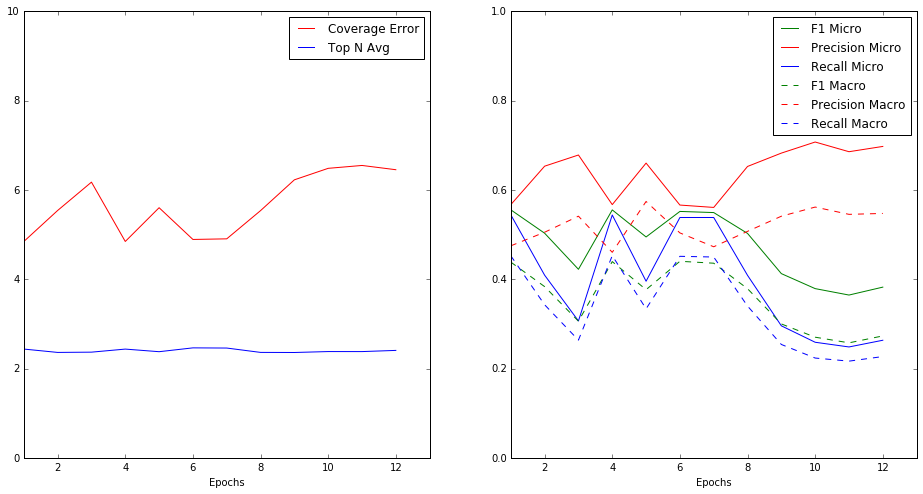

In [30]:
%matplotlib inline
coverage_errors = []
topN_avgs = []
f1_micros =  []
precision_micros = []
recall_micros = []
f1_macros =  []
precision_macros = []
recall_macros = []
epochs = []
for epoch in range(1,DOC2VEC_MAX_EPOCHS+1):
    try:
        model_name = placeholder_model_name.format(epoch)
        metrics = pickle.load(open(os.path.join(doc2vec_model_save_location, model_name, METRICS)))
        coverage_errors.append(coverage_error(metrics['y_true'], metrics['y_binary_score']))
        topN_avgs.append(metrics['topN_avg'])
        f1_micros.append(metrics['f1_micro'])
        precision_micros.append(metrics['precision_micro'])
        recall_micros.append(metrics['recall_micro'])
        f1_macros.append(metrics['f1_macro'])
        precision_macros.append(metrics['precision_macro'])
        recall_macros.append(metrics['recall_macro'])
        epochs.append(epoch)
    except Exception:
        break
fig = plt.figure(figsize=(16,8), dpi=120)
plt.subplot(121)
coverage_error_line, = plt.plot(epochs, coverage_errors, 'r-', label='Coverage Error')
topN_avg_line, = plt.plot(epochs, topN_avgs, 'b-', label='Top N Avg')
plt.legend(handles=[coverage_error_line, topN_avg_line])
plt.xlabel("Epochs")
plt.axis([1,epoch, 0, 10])

plt.subplot(122)
f1_micro_line, = plt.plot(epochs, f1_micros, 'g-', label='F1 Micro')
precision_micro_line, = plt.plot(epochs, precision_micros, 'r-', label='Precision Micro')
recall_micro_line, = plt.plot(epochs, recall_micros, 'b-', label='Recall Micro')
f1_macro_line, = plt.plot(epochs, f1_macros, 'g--', label='F1 Macro')
precision_macro_line, = plt.plot(epochs, precision_macros, 'r--', label='Precision Macro')
recall_macro_line, = plt.plot(epochs, recall_macros, 'b--', label='Recall Macro')
plt.legend(handles=[f1_micro_line, precision_micro_line, recall_micro_line, f1_macro_line, precision_macro_line, recall_macro_line])
plt.xlabel("Epochs")
plt.axis([1,epoch, 0, 1])
print f1_micros

<IPython.core.display.Javascript object>


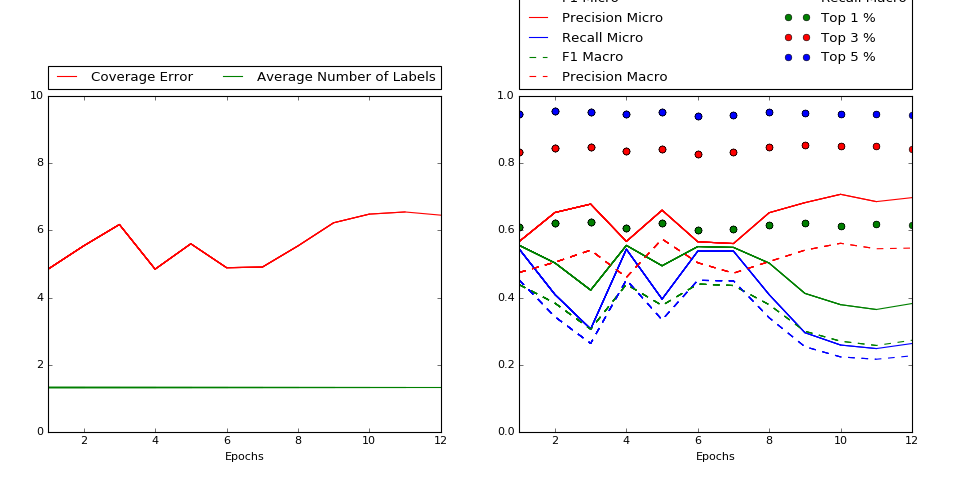

In [75]:
%matplotlib notebook
graph = MetricsGraph()
graph.init_graph()

for epoch in range(1,DOC2VEC_MAX_EPOCHS+1):
    try:
        model_name = placeholder_model_name.format(epoch)
        metrics = pickle.load(open(os.path.join(doc2vec_model_save_location, model_name, METRICS)))
        graph.add_metrics_to_graph(metrics, epoch)
    except Exception:
        break

In [90]:
validation_vectors_matrix.shape

(5457, 1000)

In [152]:
print "lskdjf"

lskdjf


In [79]:
doc2vec_model.alpha

0.024

In [119]:
[metric['coverage_error'] for metric in epoch_metrics]

[6.0518029456576938,
 4.3138649060436771,
 3.7851701371254443,
 1.4565769426104622,
 1.3819197562214323]

In [118]:
[metric['f1_micro'] for metric in epoch_metrics]

[0.54857142857142849,
 0.5620838229533881,
 0.54473738841602659,
 0.34408602150537637,
 0.32672983060579963]

In [87]:
epoch_metrics[2]

{'average_num_of_labels': 1.3519553072625698,
 'average_precision_macro': 0.62302616614963602,
 'average_precision_micro': 0.61208739711365046,
 'coverage_error': 3.6353478923311324,
 'f1_macro': 0.48459584410527123,
 'f1_micro': 0.56405990016638929,
 'f1_scores_array': [0.6084724005134788,
  0.4574162679425837,
  0.7073170731707318,
  0.3741007194244605,
  0.0,
  0.5020576131687242,
  0.629500580720093,
  0.5979020979020979],
 'precision_macro': 0.5861309895614768,
 'precision_micro': 0.63187325256290772,
 'precision_scores_array': [0.5895522388059702,
  0.6035353535353535,
  0.6157112526539278,
  0.8666666666666667,
  0.0,
  0.7134502923976608,
  0.6691358024691358,
  0.6309963099630996],
 'recall_macro': 0.45201123608467181,
 'recall_micro': 0.50939143501126971,
 'recall_scores_array': [0.6286472148541115,
  0.3682588597842835,
  0.830945558739255,
  0.23853211009174313,
  0.0,
  0.3873015873015873,
  0.5942982456140351,
  0.5681063122923588],
 'topN_avg': 2.3869984763839511,
 'topN

In [156]:
metrics

{'average_num_of_labels': 1.1684075499358622,
 'average_precision_macro': 0.5730254718709914,
 'average_precision_micro': 0.5730254718709914,
 'coverage_error': 0.0,
 'f1_macro': 0.0,
 'f1_micro': 0.0,
 'f1_scores_array': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'precision_macro': 0.0,
 'precision_micro': 0.0,
 'precision_scores_array': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'recall_macro': 0.0,
 'recall_micro': 0.0,
 'recall_scores_array': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'topN_avg': 1.1684075499358622,
 'topN_list': [0,
  0,
  8,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  8,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  8,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  8,
  0,
  0,
  8,
  8,
  0,
  0,
  0,
  0,
  0,
  8,
  0,
  0,
  8,
  0,
  8,
  0,
  0,
  0,
  0,
  8,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

In [117]:
model.reset_from(loaded_model)

2016-08-16 15:49:28,921 : INFO : using concatenative 6800-dimensional layer1
using concatenative 6800-dimensional layer1
2016-08-16 15:49:28,925 : INFO : resetting layer weights
resetting layer weights


#### Now for the actual training

In [ ]:
%%time
model.build_vocab(sentences=LabeledLineSentence(training_file), progress_per=REPORT_VOCAB_PROGRESS)

2016-08-21 05:36:43,143 : INFO : collecting all words and their counts
2016-08-21 05:36:43,576 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
